In [1]:
from qacits import calibrate_qacits, run_qacits
import heeps
from heeps.util.coord import disk_coord, mas2rms, rms2mas
from heeps.util.lamD import get_lamD_pix, get_lamD_mas
from heeps.util.img_processing import resize_img
from heeps.contrast.background import background
import numpy as np
import astropy.units as u
import astropy.convolution as astroconv
from astropy.io import fits
import os
from copy import deepcopy
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Input parameters

dits = [0.1 0.5 1.  2.  4. ] s
calib drift = 120 points in each direction


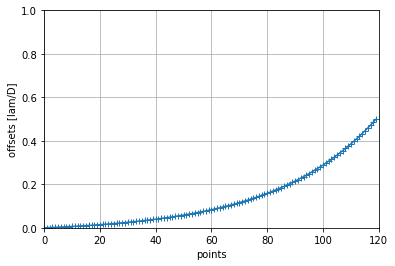

In [2]:
# files
f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_100ms_0piston_meters_scao_only_%s_%s.fits'
f_point_err = 'wavefront/point/point_qacits_1mas_0.01-0.1Hz_3600s_100ms_%s.fits'
# pupil sizes
npupils = {'L': 285,
          'N2': 119}
# mags range
rmags = {'L': np.arange(6, 12+1),
        'N2': np.arange(0, 6+1)}
# define DITs (detector integration times) via downsample ratios
down_rats = np.array([1, 5, 10, 20, 40])
dit0 = 0.1 # time per frame
dits = dit0*down_rats
print('dits = %s s'%dits)
# define calibration drift
logb = .02
npts = 120
xy = np.logspace(np.log10(logb), np.log10(.5 + logb), npts) - logb
print('calib drift = %s points in each direction'%len(xy))
plt.plot(xy,'-+')
plt.xlim(0, len(xy))
plt.ylim(0, 1)
plt.xlabel('points')
plt.ylabel('offsets [lam/D]')
plt.grid(True), plt.grid(which='minor', linestyle=':')

# qacits estimator
force = 'outer'# None# 

In [3]:
rstar_catalog = {'alphaCen': 4.26, # mas
                 'pi1Gru': 9.18, # mas
                 }
def get_fp_offsets(target, diam_ext=36.905, nr=4, disp=True):
    if target in rstar_catalog:
        rstar = rstar_catalog[target]
        fp_offsets_mas = disk_coord(rstar, nr=nr)
        fp_offsets = mas2rms(fp_offsets_mas, diam_ext)
    else:
        fp_offsets = None
    # scatter plot
    if fp_offsets is not None and disp is True:
        print('noffsets = %s'%len(fp_offsets))
        plt.scatter(fp_offsets_mas[:,0], fp_offsets_mas[:,1])
        circ = plt.Circle((0,0), rstar, linestyle=':', color='k', fill=False)
        ax = plt.gca()
        ax.add_artist(circ)
        ax.axis('equal')
        plt.xlabel('x [mas]')
        plt.ylabel('y [mas]')
        plt.title('R = %s mas (%s) - %s pts'%(rstar, target, len(fp_offsets)))
    return fp_offsets

def downsample_arr(arr, downsample_ratio=1):
    new_arr = np.array(arr).reshape(-1, downsample_ratio, *arr.shape[1:]).mean(axis = 1)
    return new_arr

def circ_drift(radii=[0.4,0.8,1.2,1.6], npts=[24,48,72,96]):
    x, y = [], []
    for r, npt in zip(radii, npts):
        xi, yi = [], []
        for t in np.arange(npt)*2*np.pi/npt:
            z = r*np.exp(1j*t)
            xi.append(np.real(z))
            yi.append(np.imag(z))
            x.append(np.real(z))
            y.append(np.imag(z))            
    xy_rms = mas2rms(np.vstack((x,y)), conf['diam_ext']) # converted to rms
    return xy_rms.T

def plot_circ_drift(tt_true, tt_est, radii=[0.4,0.8,1.2,1.6]):
    plt.figure()
    plt.scatter(tt_true[:,0], tt_true[:,1], label='tt_true', s=.5)
    plt.scatter(tt_est[:,0], tt_est[:,1], label='tt_est', s=1, color='r')
    for r in radii:
        circ = plt.Circle((0,0), r, linestyle=':', color='C0', fill=False, label='r = %s mas'%r)#, label='r = %s mas'%r
        ax = plt.gca()
        ax.add_artist(circ)
        
    plt.legend()
    ax = plt.gca()
    ax.axis('equal')
    ax.grid(True)
    plt.xlabel('x [mas]')
    plt.ylabel('y [mas]');

def create_psfs(band, mode, ls_params, pupil_shape, case, target='', ls_misalign=None, 
                zern=None, pup=None, down_rat=10, savefits=True, verbose=True):
    # update case name
    if ls_misalign is not None:
        case += '_misalign_%s_%s'%(*ls_misalign,)
    if zern is not None:
        case += '_zern_%s_%.2e'%(*zern,)
    if pup is not None:
        case += '_blur'
    # initialize conf
    dir_output = os.path.join('output_files/qacits_%s/%s_%s'%(pupil_shape, band, mode), 
            target, case)
    nframes = 2*len(xy)*down_rat
    conf = dict(dir_output=dir_output, band=band, mode=mode, nframes=nframes,
        dit=dit0, zern=zern, add_phase=True, add_point_err=True)
    if pupil_shape == 'circ':
        conf.update(f_pupil='', spi_width=0, seg_width=0, seg_gap=0)
        conf['ls_ext_circ'], conf['ls_int_circ'] = True, True
    else:
        conf.update(f_pupil='pupil/ELT_fullM1.fits')
        conf['ls_ext_circ'], conf['ls_int_circ'] = False, False
    conf['ls_dRext'], conf['ls_dRint'], conf['ls_dRspi'] = ls_params
    conf['ls_misalign'] = ls_misalign
    conf['fp_offsets'] = get_fp_offsets(target)
    conf['f_phase'] = f_phase%(band, npupils[band])
    conf['f_point_err'] = f_point_err%band
    conf = heeps.config.read_config(verbose=False, **conf)
    conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)
    # load errors
    phase_screens, amp_screens, tiptilts, apo_misaligns, ls_misaligns \
            = heeps.wavefront.load_errors(verbose=False, **conf)
    phase_screens = downsample_arr(phase_screens, downsample_ratio=down_rat)
    tiptilts = downsample_arr(tiptilts, downsample_ratio=down_rat)
    # linear tiptilt
    lamD = get_lamD_mas(**conf)
    xy_rms = mas2rms(xy*lamD, conf['diam_ext']) # converted to mas, then to rms
    tt_calib = np.array([(x,0) for x in xy_rms] + [(0,y) for y in xy_rms])
    # choose case
    if verbose is True:
        print('\nCase = %s'%case)
    if 'calib' in case:
        tiptilts = tt_calib
    elif 'circ_drift' in case:
        tiptilts = circ_drift()
    else: # random_drift
        pass
    if 'scao' not in case:
        phase_screens = np.array([None]*len(tiptilts))
    # load PSFs
    try:
        psf_OFF = fits.getdata(os.path.join(conf['dir_output'], 
            'offaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        psf_ON = fits.getdata(os.path.join(conf['dir_output'], 
            'onaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        if verbose is True:
            print('Loading PSFs')
    except FileNotFoundError:
        # initialize wavefront
        wf = heeps.pupil.pupil(pup=pup, savefits=savefits, verbose=verbose, **conf)
        # off-axis PSF
        psf_OFF = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=savefits, 
                verbose=verbose, **conf)
        # on-axis PSFs
        psf_ON = heeps.wavefront.propagate_cube(wf, phase_screens=phase_screens,
                amp_screens=amp_screens, tiptilts=tiptilts, apo_misaligns=apo_misaligns, 
                ls_misaligns=ls_misaligns, onaxis=True, savefits=savefits, verbose=verbose, **conf)
    # tiptilts in lam/D
    tt_lamD = rms2mas(tiptilts, conf['diam_ext'])/lamD # converted to mas, then to lam/D
    return conf, psf_ON, psf_OFF, tt_lamD

def point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params=None, down_rat=10, show_fig=True):
    # QACITS tip-tilt estimate
    img_sampling = get_lamD_pix(**conf)
    tiptilt_estimate = run_qacits(psf_ON, psf_OFF, img_sampling, force=force, **qacits_params)
    # convert to mas
    lamD = get_lamD_mas(**conf)
    tt_est = -tiptilt_estimate[:,0:2]*lamD
    tt_true = tt_lamD*lamD
    # rms error
    dist = np.sqrt((tt_est[:,0]-tt_true[:,0])**2 + (tt_est[:,1]-tt_true[:,1])**2)
    rms = np.sqrt(np.mean(dist**2))
    # figure
    if show_fig is True:
        ts = np.arange(len(tt_lamD))*conf['dit']*down_rat
        fig, (a0, a1, a2) = plt.subplots(3, 1, figsize=(10,6), sharex=True)
        fig.subplots_adjust(hspace=0)
        a0.plot(ts, tt_true[:,0], label='error signal', color='k', linestyle='--')
        a0.plot(ts, tt_est[:,0], label='QACITS estimate')
        a0.set_title('correction at %s band'%conf['band'])
        a0.set_ylabel('x-tilt (mas)')
        a0.legend(loc='upper right'); a0.grid(True)
        a0.set_xlim((0, ts[-1]))
        a1.plot(ts, tt_true[:,1], label='error signal', color='k', linestyle='--')
        a1.plot(ts, tt_est[:,1], label='QACITS estimate')
        a1.set_ylabel('y-tilt (mas)')
        a1.legend(loc='upper right'); a1.grid(True)
        a1.set_xlim((0, ts[-1]))
        a2.plot(ts, dist, label='%.2f mas rms'%rms)
        a2.set_xlabel('Duration (s)')
        a2.set_ylabel('Residuals (mas)')
        a2.legend(loc='upper right'); a2.grid(True)
        a2.set_xlim((0, ts[-1]))
        a2.set_ylim(bottom=0)
    return rms, tt_true, tt_est

def rms_mag(conf, psfs, psf, tt_lamD, qacits_params, mags, ymax=10):
    try:
        rms_arr = fits.getdata(os.path.join(conf['dir_output'], 
            'rms_arr_%s_%s.fits'%(conf['band'], conf['mode'])))
        print('Loading RMS array')
    except FileNotFoundError:
        print('mags = %s'%mags)
        rms_arr = np.empty((len(dits), len(mags)))
        for i, (conf['dit'], down_rat) in enumerate(zip(dits, down_rats)):
            if i == 0:
                print('DIT = %s s'%round(conf['dit'], 1), end='')
            else:
                print(', %s s'%round(conf['dit'], 1), end='')
            for j, conf['mag'] in enumerate(mags):
                psf_ON, psf_OFF = background(deepcopy(psfs), deepcopy(psf), **conf)
                # various DITs
                psf_down = downsample_arr(psf_ON, downsample_ratio=down_rat)
                tt_down = downsample_arr(tt_lamD, downsample_ratio=down_rat)
                rms, _, _ = point_err_rms(conf, psf_down, psf_OFF, tt_down,
                                          qacits_params, show_fig=False)
                rms_arr[i,j] = rms
        fits.writeto(os.path.join(conf['dir_output'], 
            'rms_arr_%s_%s.fits'%(conf['band'], conf['mode'])), np.float32(rms_arr))
    # figure
    plt.figure(figsize=(9, 5))
    for dit, rms in zip(dits, rms_arr):
        plt.plot(mags, rms, label='DIT = %s s'%round(dit, 1))
    plt.legend()
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))    
    plt.xlim(min(mags), max(mags))
    plt.ylim(1e-1, ymax)
    plt.xlabel('Star mag')
    plt.ylabel('Residual pointing error (mas rms)')

# 1) L-band CVC

In [4]:
band = 'L'
mode = 'CVC'
ls_params = [0.0209, 0.09, 0.0245]

## 1.1) Circular pupil, calibration (0-0.5 lambda/D)


Case = calib
Loading PSFs
psf_flux = 0.26627 (photutils is True)

Model calibration results:
Inner slope = 0.384
Outer slope = 0.175
Full coeff  = 0.986


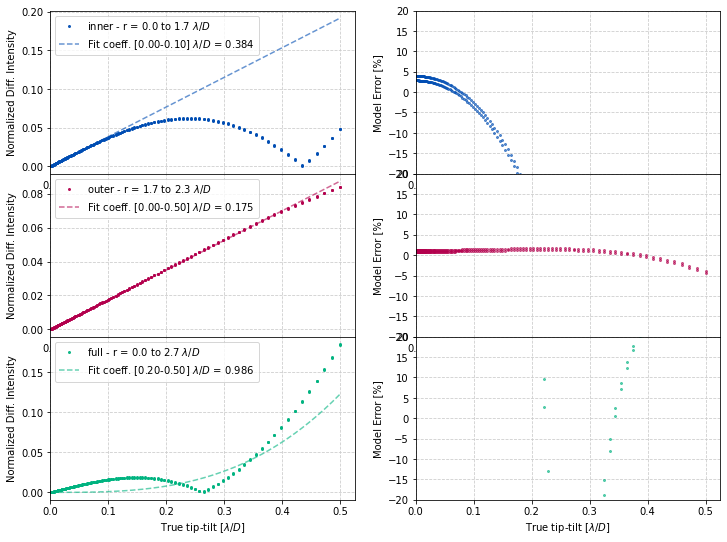

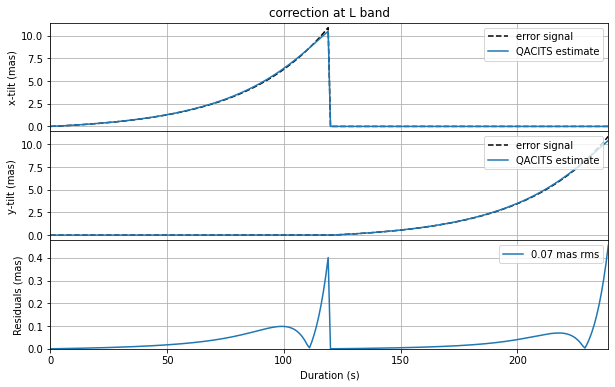

In [5]:
pupil_shape = 'circ'
case = 'calib'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
img_sampling = get_lamD_pix(**conf)
qacits_params = dict(coeffs = calibrate_qacits(psf_ON, psf_OFF, img_sampling, tt_lamD, plot_fig=True, verbose=True))
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);

## 1.2) Full M1, calibration (0-0.5 lambda/D)


Case = calib
Loading PSFs
psf_flux = 0.26044 (photutils is True)

Model calibration results:
Inner slope = 0.217
Outer slope = 0.121
Full coeff  = 1.404


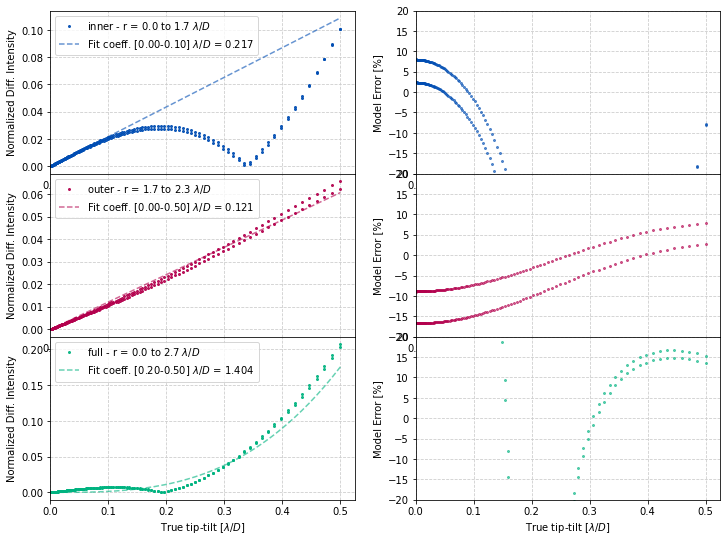

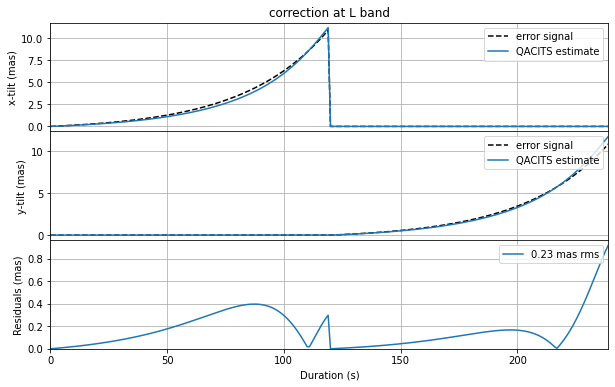

In [6]:
pupil_shape = 'fullM1'
case = 'calib'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
img_sampling = get_lamD_pix(**conf)
qacits_params = dict(coeffs = calibrate_qacits(psf_ON, psf_OFF, img_sampling, tt_lamD, plot_fig=True, verbose=True))
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);

## 1.3) Circular drift [0.4, 0.8, 1.2, 1.6] mas


Case = circ_drift
Loading PSFs


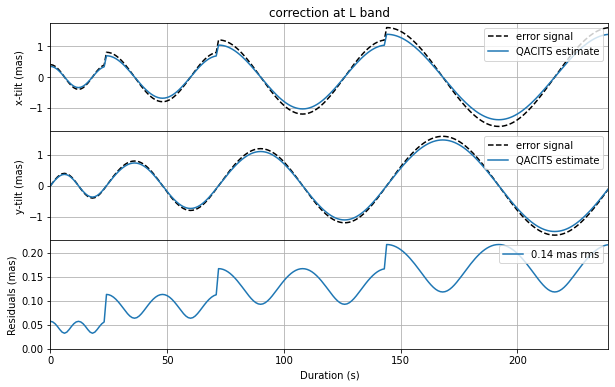

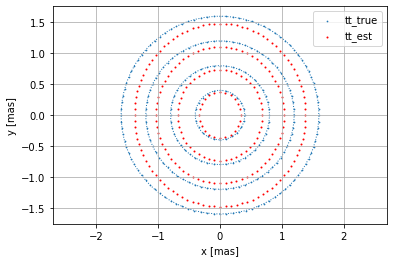

In [7]:
case = 'circ_drift'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
_, tt_true, tt_est = point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);
plot_circ_drift(tt_true, tt_est)

### X-axis LS misalignment (1%)


Case = circ_drift_misalign_0.01_0
Loading PSFs


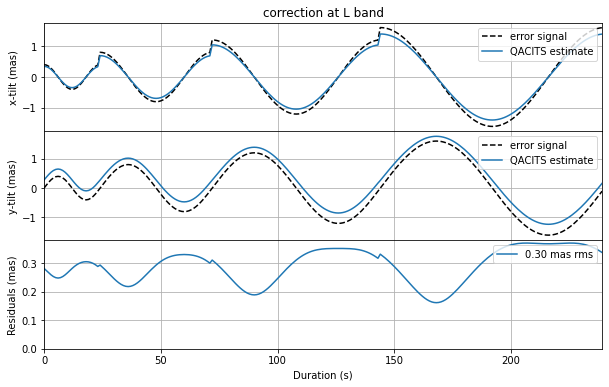

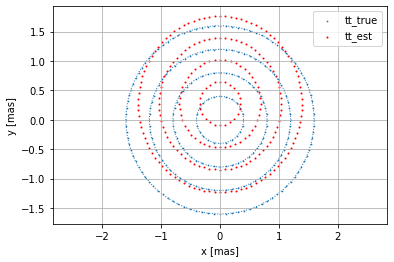

In [8]:
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, ls_misalign=[0.01, 0])
_, tt_true, tt_est = point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);
plot_circ_drift(tt_true, tt_est)

### Y-axis LS misalignment (1%)


Case = circ_drift_misalign_0_0.01
Loading PSFs


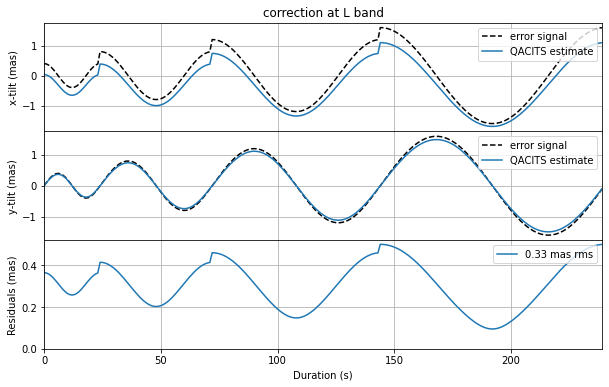

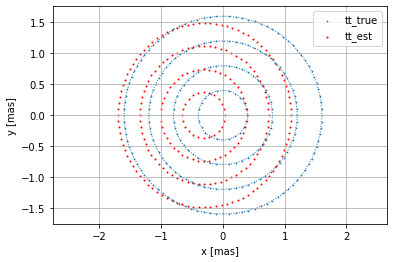

In [9]:
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, ls_misalign=[0, 0.01])
_, tt_true, tt_est = point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);
plot_circ_drift(tt_true, tt_est)

## 1.4) Circular drift + SCAO residuals (1s DIT, 10 frames averaged)


Case = scao+circ_drift
Loading PSFs


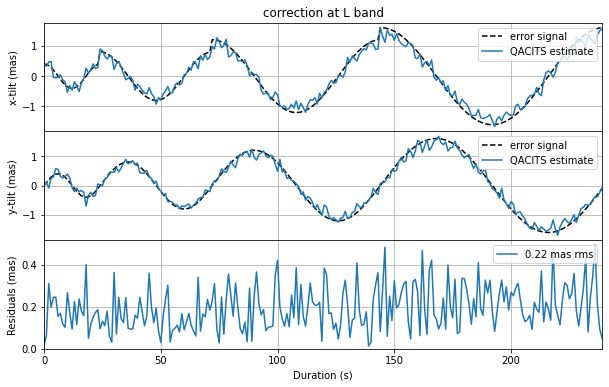

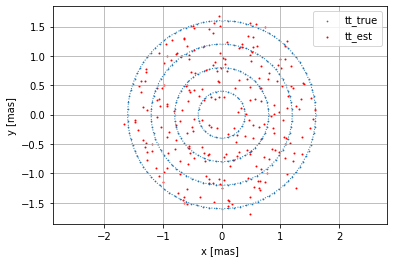

In [10]:
case = 'scao+circ_drift'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
_, tt_true, tt_est = point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);
plot_circ_drift(tt_true, tt_est)

### X-axis LS misalignment (1%)


Case = scao+circ_drift_misalign_0.01_0
Loading PSFs


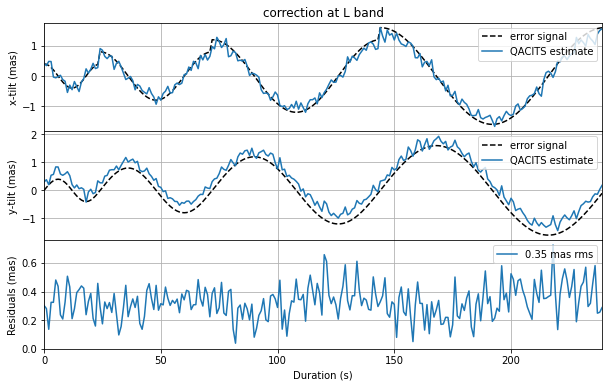

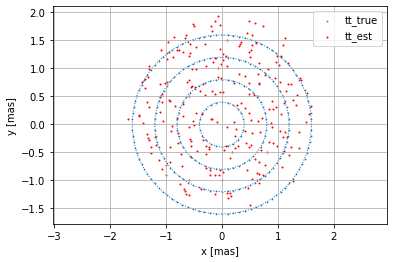

In [11]:
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, ls_misalign=[0.01, 0])
_, tt_true, tt_est = point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);
plot_circ_drift(tt_true, tt_est)

### Y-axis LS misalignment (1%)


Case = scao+circ_drift_misalign_0_0.01
Loading PSFs


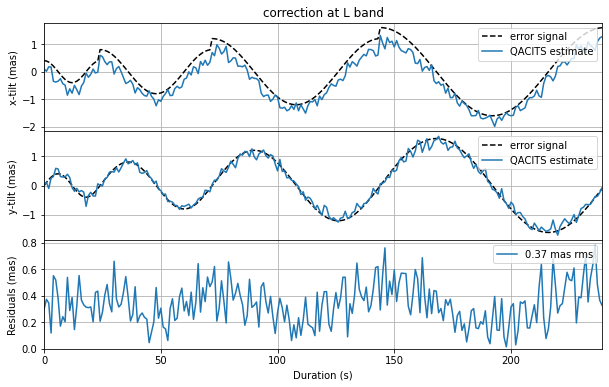

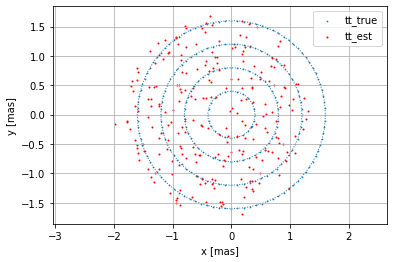

In [12]:
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, ls_misalign=[0, 0.01])
_, tt_true, tt_est = point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);
plot_circ_drift(tt_true, tt_est)

## 1.5) random pointing error: 1 mas rms, synthetic PSD range 0.01-0.1 Hz  (DIT = 1 s)


Case = random_drift_1s
Loading PSFs


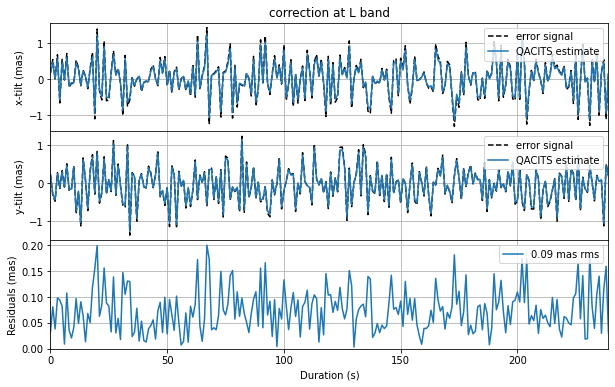

In [13]:
case = 'random_drift_1s'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);

## 1.6) random pointing error + SCAO residuals (DIT = 1 s)


Case = scao+random_drift_1s
Loading PSFs


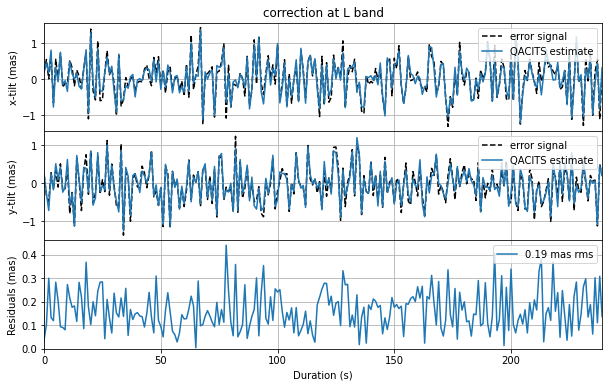

In [14]:
case = 'scao+random_drift_1s'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);

## 1.7) Star magnitude vs. DIT


Case = scao+random_drift_100ms
Loading PSFs
Loading RMS array


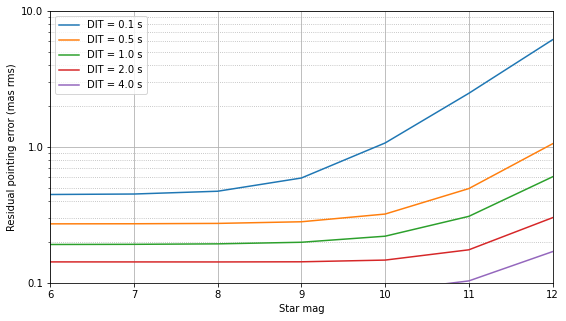

In [15]:
case = 'scao+random_drift_100ms'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, down_rat=1)
rms_mag(conf, psf_ON, psf_OFF, tt_lamD, qacits_params, rmags[band], ymax=10)

## 1.8) Influence of low order aberrations

In [16]:
case = 'scao+random_drift_1s'

### astigmatism

(nm,mas) = (0,0.19) (5,0.19) (10,0.19) (15,0.19) (20,0.19) (25,0.19) (30,0.20) (35,0.20) (40,0.21) (45,0.21) (50,0.22) 

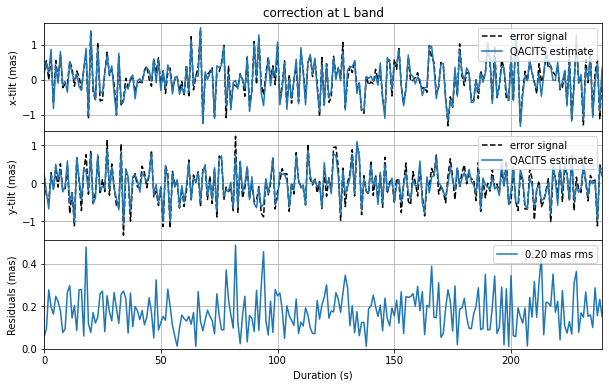

In [17]:
vals = np.arange(0, 51, 5)*1e-9
rms_astig = []
print('(nm,mas) =', end=' ')
for astigmatism in vals:
    conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case,
                                                 zern=[5, astigmatism], verbose=False)
    rms, _, _ = point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params,
                              show_fig=np.allclose(astigmatism*1e9, 30))
    print('(%d,%.2f)'%(astigmatism*1e9, rms), end=' ')
    rms_astig.append(rms)

### coma

(nm,mas) = (0,0.19)(5,0.27)(10,0.42)(15,0.60)(20,0.78)(25,0.96)(30,1.14)(35,1.32)(40,1.51)(45,1.69)(50,1.88)

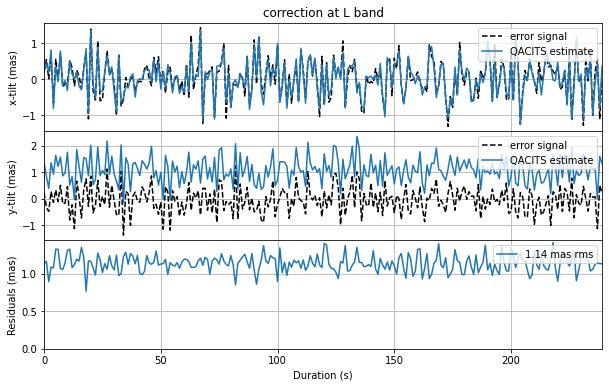

In [18]:
rms_coma = []
print('(nm,mas) =', end=' ')
for coma in vals:
    conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case,
                                                 zern=[7, coma], verbose=False)
    rms, _, _ = point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params,
                              show_fig=np.allclose(coma*1e9, 30))
    print('(%d,%.2f)'%(coma*1e9, rms), end='')
    rms_coma.append(rms)

### trefoil

(nm,mas) = (0,0.19)(5,0.19)(10,0.20)(15,0.20)(20,0.22)(25,0.23)(30,0.25)(35,0.26)(40,0.28)(45,0.30)(50,0.32)

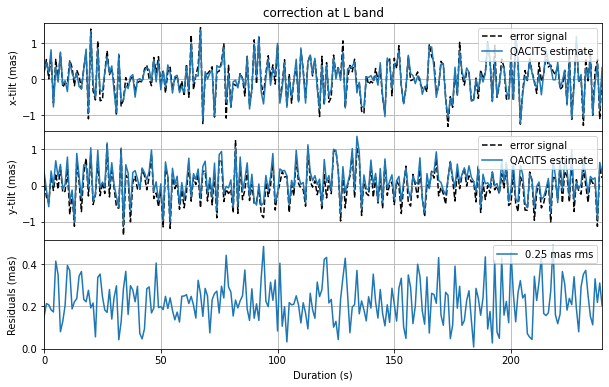

In [19]:
rms_tref = []
print('(nm,mas) =', end=' ')
for tref in vals:
    conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case,
                                                 zern=[9, tref], verbose=False)
    rms, _, _ = point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params,
                              show_fig=np.allclose(tref*1e9, 30))
    print('(%d,%.2f)'%(tref*1e9, rms), end='')
    rms_tref.append(rms)

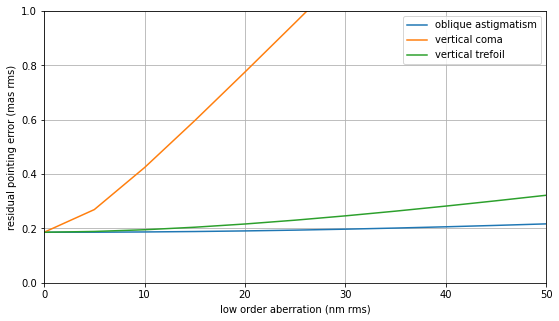

In [20]:
plt.figure(figsize=(9,5))
plt.plot(vals*1e9, rms_astig, label='oblique astigmatism')
plt.plot(vals*1e9, rms_coma, label='vertical coma')
plt.plot(vals*1e9, rms_tref, label='vertical trefoil')
plt.legend()
plt.grid()
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.xlabel('low order aberration (nm rms)')
plt.ylabel('residual pointing error (mas rms)');

## 1.9) Pupil blurring due to LMS pick-off beamsplitter

kernel shape = (255, 255)


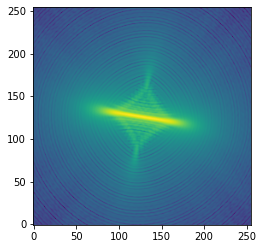

In [21]:
blurring_data = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/optics'))
f_kernel = os.path.join(blurring_data, 'IMG_LM3as_LMS_PO_pp1.txt')
kernel = np.loadtxt(f_kernel, delimiter='\t', encoding='utf-16', skiprows=21)[1:,1:]
plt.imshow(np.log10(kernel), origin='lower');
print('kernel shape =', kernel.shape)

pupil initial shape = (467, 467)


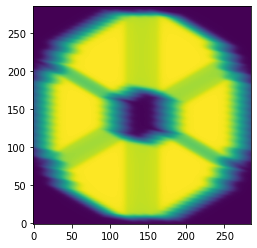

In [22]:
# load oversized pupil (pick-off case)
eso = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil/eso'))
f_pup = os.path.join(eso, 'pup_M1.pkl')
pup = pickle.load(open(f_pup,'rb'))['PKF']
print('pupil initial shape =', pup.shape)
# convolve pupil with kernel
pup_conv = astroconv.convolve(pup, kernel, boundary='extend')
# resize and normalize (total flux = 1)
pup_conv = resize_img(pup_conv, npupils[band])
I_pup = pup_conv**2
pup_conv = np.sqrt(I_pup/np.sum(I_pup))
plt.imshow(pup_conv, origin='lower');


Case = scao+random_drift_1s_blur
Loading PSFs


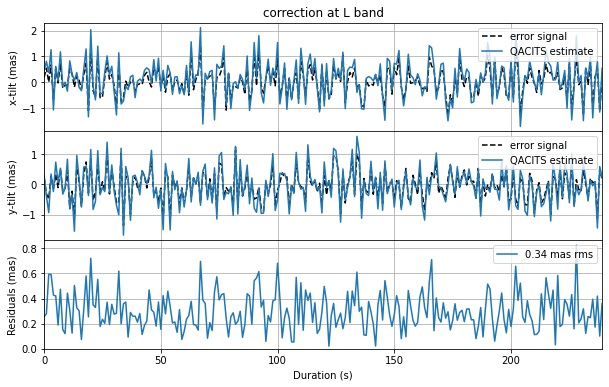

In [23]:
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, pup=pup_conv)
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);

### solution 1: recalibrate QACITS with blurred pupil


Case = calib_blur
Loading PSFs
psf_flux = 0.26308 (photutils is True)

Model calibration results:
Inner slope = 0.204
Outer slope = 0.156
Full coeff  = 2.116

Case = scao+random_drift_1s_blur
Loading PSFs


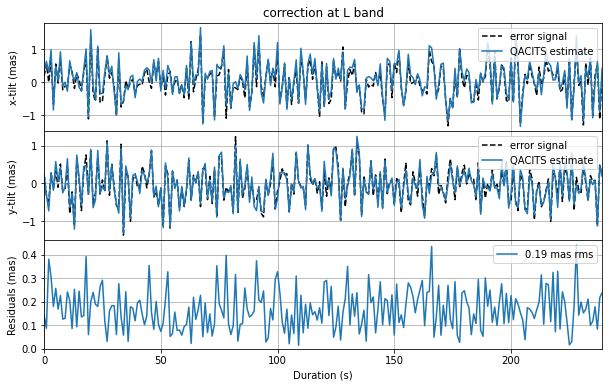

In [24]:
case = 'calib'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, pup=pup_conv)
img_sampling = get_lamD_pix(**conf)
qacits_params = dict(coeffs = calibrate_qacits(psf_ON, psf_OFF, img_sampling, tt_lamD, plot_fig=False, verbose=True))
case = 'scao+random_drift_1s'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, pup=pup_conv)
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);

### solution 2: use backup lyot stop (need to calibrate QACITS for this LS)


Case = bkp_calib
Loading PSFs
psf_flux = 0.17287 (photutils is True)

Model calibration results:
Inner slope = 0.242
Outer slope = 0.146
Full coeff  = 1.585

Case = bkp_scao+random_drift_1s_blur
Loading PSFs


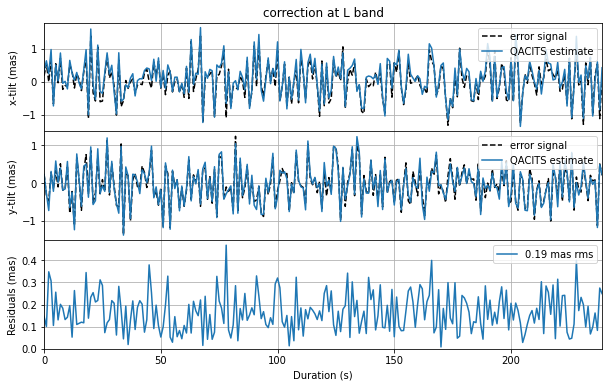

In [25]:
ls_params = [0.08, 0.09, 0.0545]
case = 'bkp_calib'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
img_sampling = get_lamD_pix(**conf)
qacits_params = dict(coeffs = calibrate_qacits(psf_ON, psf_OFF, img_sampling, tt_lamD, plot_fig=False, verbose=True))
case = 'bkp_scao+random_drift_1s'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, pup=pup_conv)
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);

## 1.10) All effects
* blured pupil (QACITS recalibrated)
* random pointing error: 1 mas rms, synthetic PSD range 0.01-0.1 Hz
* SCAO residuals 
* star mag L=6
* DIT = 1s
* X-axis LS misalignment (1%)
* coma: 3 nm rms


Case = calib_blur
Loading PSFs
psf_flux = 0.26308 (photutils is True)

Model calibration results:
Inner slope = 0.204
Outer slope = 0.156
Full coeff  = 2.116

Case = scao+random_drift_1s_misalign_0.01_0_zern_7_3.00e-09_blur
Loading PSFs


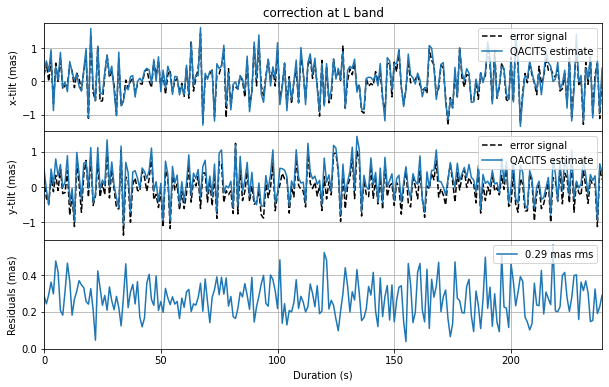

In [26]:
ls_params = [0.0209, 0.09, 0.0245]
case = 'calib'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, pup=pup_conv)
img_sampling = get_lamD_pix(**conf)
qacits_params = dict(coeffs = calibrate_qacits(psf_ON, psf_OFF, img_sampling, tt_lamD, plot_fig=False, verbose=True))
case = 'scao+random_drift_1s'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, pup=pup_conv, ls_misalign=[0.01, 0], zern=[7, 3e-9])
conf['mag'] = 6
psf_ON, psf_OFF = background(psf_ON, psf_OFF, **conf)
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);

# 2) L-band RAVC

In [27]:
band = 'L'
mode = 'RAVC'
ls_params = [0.0477, 0.04, 0.0249]

## 2.1) Calibration (0-0.5 lambda/D)


Case = calib
Loading PSFs
psf_flux = 0.08811 (photutils is True)

Model calibration results:
Inner slope = 0.026
Outer slope = 0.028
Full coeff  = 2.354


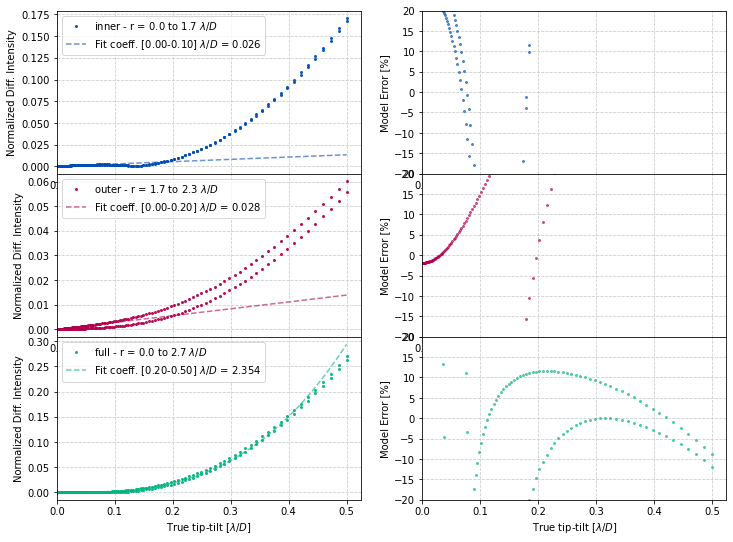

In [28]:
pupil_shape = 'fullM1'
case = 'calib'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
img_sampling = get_lamD_pix(**conf)
tt_fit_lim={'inner':(0,0.1),'outer':(0,0.2),'full':(0.2,0.5)}
qacits_params = dict(coeffs = calibrate_qacits(psf_ON, psf_OFF, img_sampling, tt_lamD, tt_fit_lim=tt_fit_lim, plot_fig=True, verbose=True))

## 2.2) random pointing error + SCAO residuals (DIT = 1 s)


Case = scao+random_drift_1s
Loading PSFs


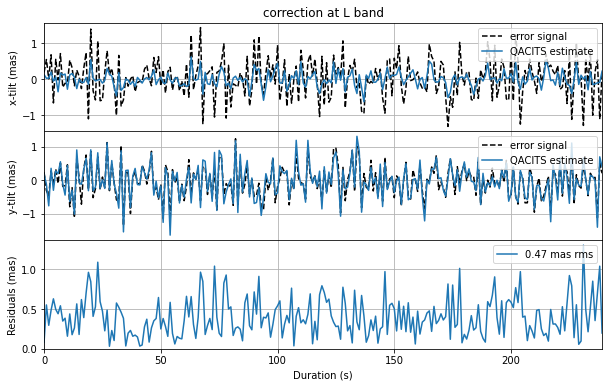

In [29]:
case = 'scao+random_drift_1s'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);


Case = scao+random_drift_100ms
Loading PSFs
Loading RMS array


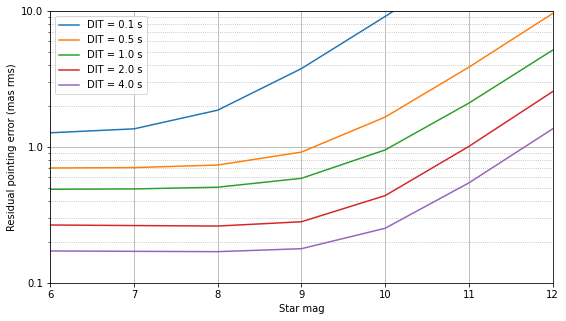

In [30]:
case = 'scao+random_drift_100ms'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, down_rat=1)
rms_mag(conf, psf_ON, psf_OFF, tt_lamD, qacits_params, rmags[band], ymax=10)

## 2.3) All effects
* blured pupil (QACITS recalibrated)
* random pointing error: 1 mas rms, synthetic PSD range 0.01-0.1 Hz
* SCAO residuals 
* star mag L=6
* DIT = 1s
* X-axis LS misalignment (1%)
* coma: 3 nm rms


Case = calib_blur
Loading PSFs
psf_flux = 0.09159 (photutils is True)

Model calibration results:
Inner slope = 0.010
Outer slope = 0.096
Full coeff  = 2.893

Case = scao+random_drift_1s_misalign_0.01_0_zern_7_3.00e-09_blur
Loading PSFs


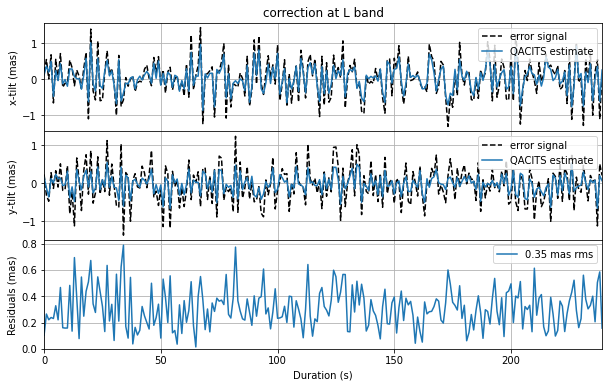

In [31]:
case = 'calib'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, pup=pup_conv)
img_sampling = get_lamD_pix(**conf)
qacits_params = dict(coeffs = calibrate_qacits(psf_ON, psf_OFF, img_sampling, tt_lamD, plot_fig=False, verbose=True))
case = 'scao+random_drift_1s'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, pup=pup_conv, ls_misalign=[0.01, 0], zern=[7, 3e-9])
conf['mag'] = 6
psf_ON, psf_OFF = background(psf_ON, psf_OFF, **conf)
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);

# 3) N-band CVC

In [32]:
band = 'N2'
mode = 'CVC'
ls_params = [0.0268, 0.09, 0.0357]

## 3.1) Calibration (0-0.5 lambda/D)


Case = calib
Loading PSFs
psf_flux = 0.2483 (photutils is True)

Model calibration results:
Inner slope = 0.216
Outer slope = 0.125
Full coeff  = 1.423


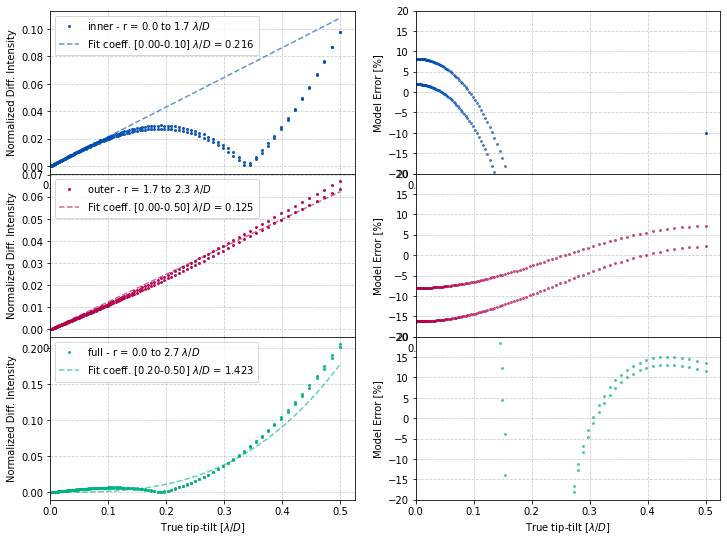

In [33]:
pupil_shape = 'fullM1'
case = 'calib'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
img_sampling = get_lamD_pix(**conf)
qacits_params = dict(coeffs = calibrate_qacits(psf_ON, psf_OFF, img_sampling, tt_lamD, plot_fig=True, verbose=True))

## 3.2) random pointing error (3 times L-band) + SCAO residuals (DIT = 1 s)


Case = scao+random_drift_1s
Loading PSFs


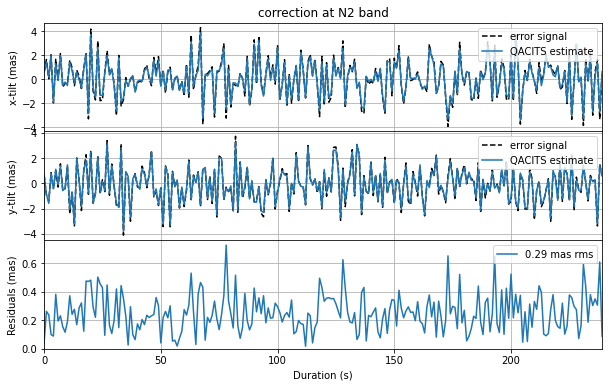

In [34]:
case = 'scao+random_drift_1s'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);


Case = scao+random_drift_100ms
Loading PSFs
Loading RMS array


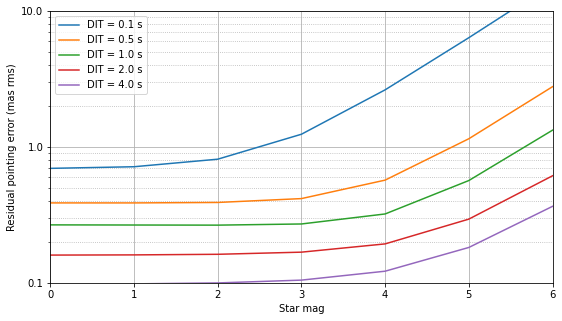

In [35]:
case = 'scao+random_drift_100ms'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, down_rat=1)
rms_mag(conf, psf_ON, psf_OFF, tt_lamD, qacits_params, rmags[band], ymax=10)

## 3.3) All effects
* random pointing error: 3 mas rms, synthetic PSD range 0.01-0.1 Hz
* SCAO residuals 
* star mag N=0
* DIT = 1s
* X-axis LS misalignment (1%)
* coma: 6 nm rms


Case = scao+random_drift_1s_misalign_0.01_0_zern_7_6.00e-09_blur
Loading PSFs


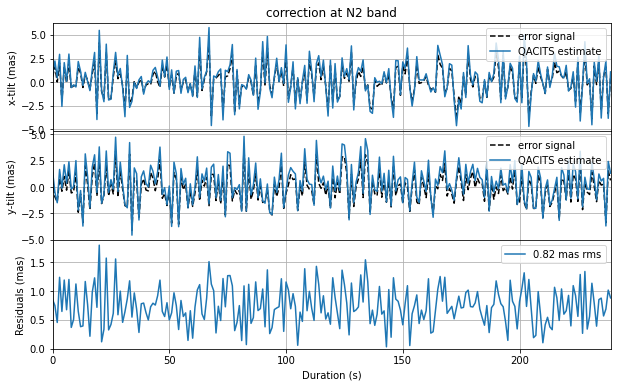

In [36]:
case = 'scao+random_drift_1s'
conf, psf_ON, psf_OFF, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, pup=pup_conv, ls_misalign=[0.01, 0], zern=[7, 6e-9])
conf['mag'] = 0
psf_ON, psf_OFF = background(psf_ON, psf_OFF, **conf)
point_err_rms(conf, psf_ON, psf_OFF, tt_lamD, qacits_params);